In [1]:
import spacy
import mailbox
import re
import pandas as pd

In [2]:
import mailbox

mbox = mailbox.mbox(r"/Users/ilya/Desktop/Computer-Science/Projects/staff_jargon/Mail/Inbox.mbox")

In [3]:
def get_text(msg):
  while msg.is_multipart():
    msg = msg.get_payload()[0]
  return msg.get_payload()

def strip_replies(text):
  lines = text.split("\n")
  lines = [l for l in lines if len(l) > 0]
  lines = [line for line in lines if line[0] != ">"]
  return "\n".join(lines)

def strip_footer(text):
  text, _ = re.subn("On (Sun|Mon|Tue|Wed|Thu|Fri|Sat),.*, 20.. at.*@gmail.com.*wrote.*",
                    "",
                    text,
                    flags=re.DOTALL)
                    
  return text

def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

def message_clean(item):
  
    item = re.sub('\r',' ', item)
    item = re.sub('\n',' ', item)
    item = re.sub('>',' ', item)
    item = re.sub('\\\\..',' ', item)
    item = re.sub('\\*', ' ', item)
    item = multiple_replace(my_dict, item)
    return item

def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

In [4]:
all_punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~='''

my_dict = dict()

for x in all_punctuations:
    my_dict[x] = ' '

In [5]:
content_list = []
from_list = []
subject_list = []

counter = 0
error_count = 0

for message in mbox:
    if bool(re.search('@italki.com', str(message['from']))) == True and bool(re.search('invitation', str(message['subject']).lower())) == False:
        text = get_text(message)
        text = remove_tags(text)
        text = message_clean(text)
        text = strip_replies(text)
        text = strip_footer(text)
        text = text.lower()
        content_list.append(text)
        from_list.append(str(message['from']))
        subject_list.append(str(message['subject']))
        
        counter = counter+1
        
        if counter%100 == 0:
            print(counter, end = ' ')

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 

In [6]:
meta_df = pd.DataFrame()

meta_df['from'] = from_list
meta_df['subject'] = subject_list
meta_df['text'] = content_list

In [7]:
all_words = str()

for content_item in content_list:
    all_words = all_words+content_item

interval1 = [i for i in range(0, len(all_words), round(len(all_words)/13))]
interval2 = [i for i in range(round(len(all_words)/13), len(all_words)+round(len(all_words)/13), round(len(all_words)/13))]

string_chunks = [all_words[i1:i2] for i1,i2 in zip(interval1, interval2)]

In [8]:
nlp = spacy.load('en_core_web_sm')
final_df = []

df_counter = 0

for chunk in string_chunks:
    doc = nlp(chunk)
    df = pd.DataFrame()
    df.loc[:,'is_stop'] = [token.is_stop for token in doc]
    df.loc[:,'text'] = [token.text for token in doc]
    df.loc[:,'pos'] = [token.pos_ for token in doc]
    df.loc[:,'lemma'] = [token.lemma_ for token in doc]
    df.loc[:,'punct'] = [token.is_punct for token in doc]
    df = df[df['is_stop'] == False]
    df = df[df['punct'] == False]
    df = df[df['pos'].isin(['ADJ','NOUN','VERB',]) == True]
    df = df[['text','lemma','pos']]
    final_df.append(df)

    df_counter = df_counter + 1
    print(df_counter, end = ' ')

final_df2 = pd.concat(final_df)

1 2 3 4 5 6 7 8 9 10 11 12 13 

In [18]:
final_df2 = final_df2[final_df2['lemma'].isin(italki_stop_words) == False]
final_df2

,text,lemma,pos
0,sprint,sprint,NOUN
1,plan,plan,NOUN
2,sprint,sprint,ADJ
3,release,release,NOUN
4,plan,plan,NOUN
...,...,...,...
740276,read,read,VERB
740277,itaki,itaki,ADJ
740278,teacher,teacher,NOUN
740279,success,success,NOUN


In [19]:
noun_df = final_df2[final_df2['pos'] == 'NOUN'].groupby('lemma').count()\
    .reset_index().sort_values(by = 'text', ascending=True).rename(columns = {'text':'app_count'})[['lemma','app_count']]

verb_df = final_df2[final_df2['pos'] == 'VERB'].groupby('lemma').count()\
    .reset_index().sort_values(by = 'text', ascending=True).rename(columns = {'text':'app_count'})[['lemma','app_count']]

adj_df = final_df2[final_df2['pos'] == 'ADJ'].groupby('lemma').count()\
    .reset_index().sort_values(by = 'text', ascending=True).rename(columns = {'text':'app_count'})[['lemma','app_count']]

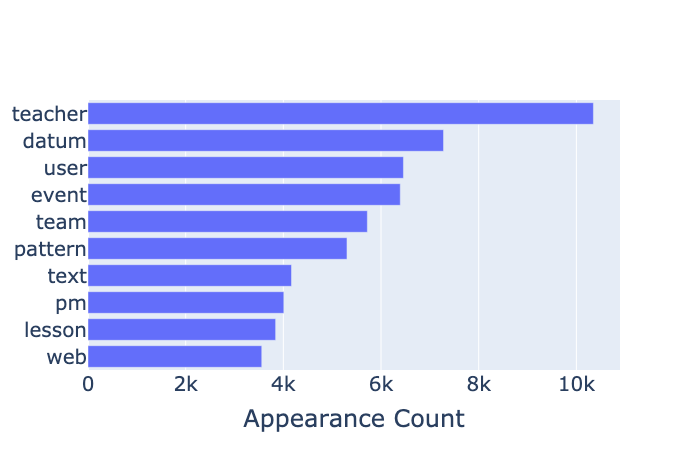

In [20]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x=noun_df.tail(10)['app_count'],
            y=noun_df.tail(10)['lemma'],
            text = noun_df.tail(10)['app_count'],
            orientation='h'))

fig.update_layout(xaxis_title = 'Appearance Count', height=1000, width = 500, font=dict(size=20))

fig.show('png')

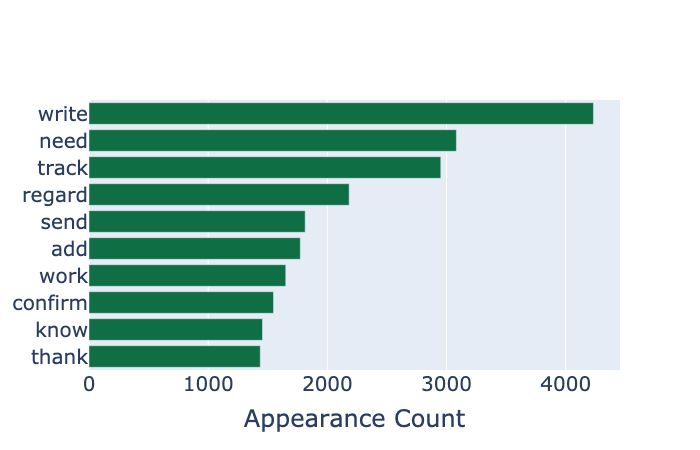

In [21]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x=verb_df.tail(10)['app_count'],
            y=verb_df.tail(10)['lemma'],
            text = verb_df.tail(10)['app_count'],
            orientation='h'))

fig.update_traces(marker_color='#106e45')

fig.update_layout(xaxis_title = 'Appearance Count', height=1000, width = 500, font=dict(size=20))

fig.show('png') 

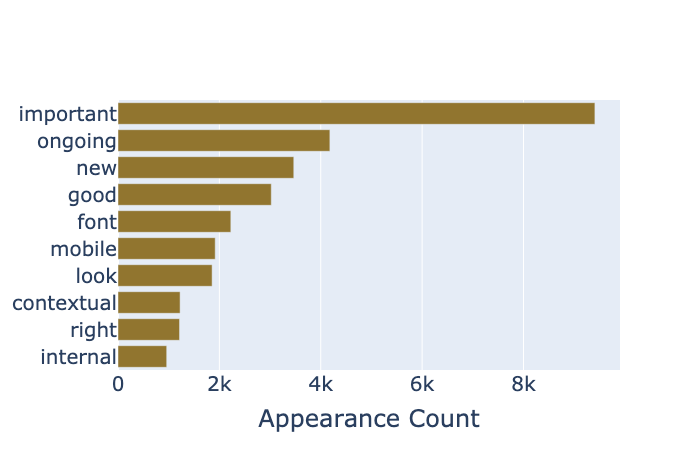

In [22]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x=adj_df.tail(10)['app_count'],
            y=adj_df.tail(10)['lemma'],
            #text = verb_df.tail(10)['app_count'],
            orientation='h'))

fig.update_traces(marker_color='#91752F')

fig.update_layout(xaxis_title = 'Appearance Count', height=1000, width = 500, font=dict(size=20))

fig.show('png')